# figure3d 
based on `[20230223]EXP11-13_embed_twister-sister-beta0p001`

In [1]:
# install 

import os 
import sys 
sys.path.append("../../src")
import preprocess
import util
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import random 
import h5py 
from models.CMVAE import CovarianceModelVAE
from Bio import SeqIO
plt.rcParams['font.family'] = 'sans-serif'


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


log_dir = "../outputs/diverse/ts"
data_dir = "../datasets/diverse/ts"
rfam = "RF02681"

In [2]:
# loading model

model = CovarianceModelVAE.build_from_config(f"../{log_dir}/config_1em3_seed17.yaml")
model.load_model_from_ckpt(f"../{log_dir}/model_epoch200_1em3_seed17.pt")
model.eval();

# embed

In [3]:
!ls ../{data_dir}/*train*h5

../../datasets/diverse/ts/RF02681_unique_tidy_notrunc_traceback_onehot_cm_train.h5
../../datasets/diverse/ts/RF02681_unique_tidy_notrunc_traceback_onehot_cm_train_weight_threshold0p05.h5


In [4]:
# get meta info
import h5py
from Bio import SeqIO
from sklearn.model_selection import train_test_split


origin_fasta = f"../{data_dir}/RF02681_unique_tidy.fa"
path_h5_train = f"../{data_dir}/RF02681_unique_tidy_notrunc_traceback_onehot_cm_train.h5"

records_iddesc = [(record.id, record.description) for record in SeqIO.parse(origin_fasta, "fasta")]
train_iddesc, _ = train_test_split(records_iddesc, test_size=0.3, random_state = 42)
data = h5py.File(path_h5_train, "r+")

if "id" in dict(data):
    del data["id"]
if "desc" in dict(data):
    del data["desc"]
    
# add id and desc
data.create_dataset("id", data=[x[0].encode() for x in train_iddesc])
data.create_dataset("desc", data=[x[1].encode() for x in train_iddesc])

data["desc"][:3]


array([b'URS0000D65CFC_12908/1-95 unclassified sequences Twister_sister_ribozyme',
       b'URS0000D677E9_12908/1-72 unclassified sequences Twister_sister_ribozyme',
       b'URS0000D6B2EB_12908/1-81 unclassified sequences Twister_sister_ribozyme'],
      dtype='|S83')

In [5]:
# load z_train with desc

def load_data_cm(path):
    data = h5py.File(path, "r")
    id_ = data["id"][:].tolist()
    desc = data["desc"][:].tolist()
    tr = torch.from_numpy(data["tr"][:]).nan_to_num(0).transpose(-2, -1).float()
    s = torch.from_numpy(data["s"][:]).transpose(-2, -1).float()
    p = torch.from_numpy(data["p"][:]).transpose(-2, -1).float()
    return id_, desc, tr, s, p


X_train_fname = f"../{data_dir}/{rfam}_unique_tidy_notrunc_traceback_onehot_cm_train.h5"
pentad = load_data_cm(X_train_fname)


z_mu_train = []
z_logvar_train = []
z_id_train = []
z_desc_train = []

for id_, desc, tr_, s_, p_ in zip(*pentad):
    tr_ = tr_.unsqueeze(0)
    s_ = s_.unsqueeze(0)
    p_ = p_.unsqueeze(0)
    mu, logvar = model.encoder((tr_, s_, p_))
    z_mu_train.append(mu.squeeze().detach().numpy())
    z_logvar_train.append(logvar.squeeze().detach().numpy())
    z_id_train.append(id_.decode())
    z_desc_train.append(desc.decode())
len(z_desc_train)

79

In [31]:
# load structure info from sto file
from Bio import AlignIO
from pprint import pprint

alignment = AlignIO.read(f"../{data_dir}/RF02681_unique_tidy_notrunc.sto", "stockholm")
ss_cons = alignment.column_annotations["secondary_structure"]
pprint(alignment.column_annotations)
print()
variable_loop = "<<<.....____~~~~~~~~~~~~~~~~~~~~~~~~~~~.......>>>"
start = ss_cons.find(variable_loop)
end   = start + len(variable_loop)

train_index, _ = train_test_split(range(len(alignment)), test_size=0.3, random_state = 42)

# check seq of train_index has variable loop
has_variable_loop = []
idx = 0
print("  ",ss_cons)
for i in train_index:
#     print(set(alignment[i].seq[start:end]))
    if set(alignment[i].seq[start:end]) == set("-"):
#         print(alignment[i].id)
#         print(alignment[i].seq[start:end])
        has_variable_loop.append(False)
        print(f"{alignment[i].id}")
        print(f"-  {alignment[i].seq}")
    else:
        has_variable_loop.append(True)
        print(f"{alignment[i].id}")

        print(f"+  {alignment[i].seq}")
    idx += 1
    if idx > 5:
        break
print(f"total\t\t\t: {len(has_variable_loop)} seq")
print(f"variable_loop+\t: {sum(has_variable_loop)} seq")



{'reference_annotation': 'auAaggcgCAAGGCCcAcgc.....aucu~~~~~~~~~~~~~~~~~~~~~~~~~~~.......gcgua..G..CCcGUGcAAGCCgGG.CcgcCccc....gaaau~~~.................................gggGgcg.GGCGCUcAu..gccuaaaaa',
 'secondary_structure': ':::((((-----(((,,<<<.....____~~~~~~~~~~~~~~~~~~~~~~~~~~~.......>>>,,..<..<<<_________>>>.><<<<<<<...._____~~~.................................>>>>>>>.)))------..)))):::::'}

   :::((((-----(((,,<<<.....____~~~~~~~~~~~~~~~~~~~~~~~~~~~.......>>>,,..<..<<<_________>>>.><<<<<<<...._____~~~.................................>>>>>>>.)))------..)))):::::
URS0000D65CFC_12908/1-95
+  ACAGACCGCCAGACCCGGCUUAUCG-------------------------------CCAGAUAAGCUAUGA--CCCGUGCAAGCCGGG-UGCGCCUC---CCGCGU-----------------------------------GGAGGCGC-GGCGCUUAU--GGUCAAGGA
URS0000D677E9_12908/1-72
-  AAAAGGCACAAGGCCCA-----------------------------------------------------G-UCCCGUGGAAGCCGGGACCGCCCC-----UUCG--------------------------------------GGGGCGCGGCGCUUAC-AGCCACAAAC
URS0000D6B2EB_12908/1-81
+  AC

'.................(((...........................................)))....(..(((.........))).)(((((((.............................................))))))).....................'

In [32]:
import util
seq,ss = util.recover_seqss_from_stk(
    seq_aligned= "ACAGACCGCCAGACCCGGCUUAUCG-------------------------------CCAGAUAAGCUAUGA--CCCGUGCAAGCCGGG-UGCGCCUC---CCGCGU-----------------------------------GGAGGCGC-GGCGCUUAU--GGUCAAGGA",
    SS_cons = alignment.column_annotations["secondary_structure"])

print(seq)
print(ss)


seq,ss = util.recover_seqss_from_stk(
    seq_aligned= "AAAAGGCACAAGGCCCA-----------------------------------------------------G-UCCCGUGGAAGCCGGGACCGCCCC-----UUCG--------------------------------------GGGGCGCGGCGCUUAC-AGCCACAAAC",
    SS_cons = alignment.column_annotations["secondary_structure"])

print(seq)
print(ss)

ACAGACCGCCAGACCCGGCUUAUCGCCAGAUAAGCUAUGACCCGUGCAAGCCGGGUGCGCCUCCCGCGUGGAGGCGCGGCGCUUAUGGUCAAGGA
:::((((.....(((,,(((............))),,..((((_________))))(((((((._____.))))))))))......)))):::::
AAAAGGCACAAGGCCCAGUCCCGUGGAAGCCGGGACCGCCCCUUCGGGGGCGCGGCGCUUACAGCCACAAAC
:::((((.....(((,,(.(((_________))).)((((((____)))))).))).......)))):::::


In [15]:
# embedding
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 


pca = PCA(n_components=2).fit(z_mu_train)
embed_tsne = TSNE(n_components=2, random_state = 42).fit_transform(z_mu_train)
embed_pca = pca.transform(z_mu_train)

embed_pca.shape

(79, 2)

(79, 2)


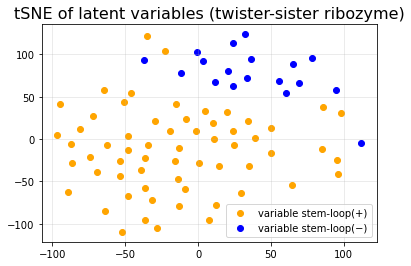

In [33]:
embed = embed_tsne

x,y = 0,1
plt.scatter(
    [embed[i][x] for i in range(len(embed)) if has_variable_loop[i]],
    [embed[i][y] for i in range(len(embed)) if has_variable_loop[i]],
    label = "variable stem-loop(+)",
    color = "orange"
    )
plt.scatter(
    [embed[i][x] for i in range(len(embed)) if not has_variable_loop[i]],
    [embed[i][y] for i in range(len(embed)) if not has_variable_loop[i]],
    label = "variable stem-loop(−)",
    color = "blue"
    )

plt.grid(alpha=0.3)
# plt.xlim(-30, 50)
plt.title(f"tSNE of latent variables (twister-sister ribozyme)", fontsize=16)
plt.legend()
print(embed.shape)
# plt.savefig(f"../../outputs/figures/figure3d.png", dpi=300, transparent = True)
# plt.savefig(f"../../outputs/figures/figure3d.pdf", transparent = True)

In [ ]:
# select sequences with/without variable loop


# figure 3c

In [13]:
# compare phylogenetic distance and lanten distance
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.Align import MultipleSeqAlignment


alignment = AlignIO.read(f"../{data_dir}/RF02681_unique_tidy_notrunc_train.sto", "stockholm")
dna_alignment = []
for aln in alignment:
    aln.seq = Seq(str(aln.seq).replace("U", "T"))
    dna_alignment.append(aln)
dna_alignment = MultipleSeqAlignment(dna_alignment)
calculator = DistanceCalculator('blosum62')
dm = calculator.get_distance(dna_alignment)

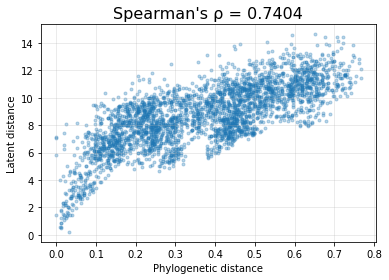

In [22]:
dm_phylo = np.array(dm)

dm_latent = np.zeros([len(z_mu_train), len(z_mu_train)])
for i in range(len(z_mu_train)):
    for j in range(len(z_mu_train)):
        dm_latent[i][j] = np.linalg.norm(z_mu_train[i] - z_mu_train[j])

dm_phylo_flatten = dm_phylo[np.triu_indices(len(dm_phylo), k=1)]
dm_latent_flatten = dm_latent[np.triu_indices(len(dm_latent), k=1)]


from scipy.stats import spearmanr
corr,p = spearmanr(dm_phylo_flatten, dm_latent_flatten)

plt.scatter(dm_phylo_flatten, dm_latent_flatten, alpha=0.3, marker=".")
plt.xlabel("Phylogenetic distance")
plt.ylabel("Latent distance")
plt.grid(alpha=0.3)
plt.title(f"Spearman's ρ = {round(corr,4)}", fontsize=16)

# plt.savefig(f"../../outputs/figures/figure3c.png", dpi=300, transparent = True)
# plt.savefig(f"../../outputs/figures/figure3c.pdf", transparent = True)

In [21]:
!ls ../{log_dir}/outputs/

ls: ../../outputs/diverse/ts/outputs/: No such file or directory
